<a href="https://colab.research.google.com/github/KaterinaKintiDS/Machine_Learning/blob/main/MT6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', 350)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from statistics import mean, stdev
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler

import imblearn
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.compose import ColumnTransformer
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
import functools
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, GridSearchCV, RandomizedSearchCV,cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer, recall_score, log_loss, confusion_matrix, precision_recall_curve, auc,accuracy_score, precision_score,  roc_curve
from sklearn.metrics import average_precision_score,precision_recall_curve, auc,  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from tabulate import tabulate

In [ ]:
qual = pd.read_pickle("FinTech3_2000.pkl")

In [ ]:
# Separate the features and target variable
X = qual.drop(['Target'], axis=1)
y = qual['Target']

In [ ]:
# calculate percentage of each class of target variable
class_ratio = y.value_counts(normalize=True) * 100
class_ratio

Target
0    99.8079
1     0.1921
Name: proportion, dtype: float64

In [ ]:
#Count classes
"Class distribution:", Counter(y)

('Class distribution:', Counter({0: 330961, 1: 637}))

In [ ]:
# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# One-hot encode categorical features using get_dummies
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


# Concatenate numerical columns from X with the one-hot encoded X
X_combined = pd.concat([X[numerical_columns], X_encoded], axis=1)


In [ ]:
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331598 entries, 2604674 to 236160
Columns: 4051 entries, IDacc to MEAS_CUSL_HAS_CONTACT_ATTEMPT_Yes
dtypes: bool(3734), float64(210), int32(25), int64(82)
memory usage: 1.9 GB


In [ ]:
# reset index
X_combined.sort_index(inplace=True)
X = X_combined.copy()
X.head()


,IDacc,SNAPNUMacc,MEAS_ACCH_ORIGINATOR,MEAS_ACCL_STRAY_PAYMENT_AMT,MEAS_ACCL_APLL_FORBORNE,MEAS_ACCL_PROMISE_ACCOUNTS,MEAS_ACCL_PROMISE_ACCOUNT,MEAS_ACCL_KEPT_ACCOUNT,MEAS_ACCL_KEPT_PROMISE,MEAS_ACCL_NUM_OF_PROMISES,MEAS_ACCL_HAS_ARRANGEMENT_FLAG,MEAS_ACCL_BROKEN_SETTLEMENT_INDICATOR_CP,MEAS_ACCL_NBR_OF_PROMISES,MEAS_ACCL_NBR_OF_UNKEPT_PROMISES,MEAS_ACCL_STATUS_PRIORITY,MEAS_ACCL_BUCKET_MAX_NBG,MEAS_ACCL_BILLING_DAY,MEAS_ACCT_BRANCH,MEAS_ACCH_ACTIVE,MEAS_ACCH_DELDAYS,MEAS_ACCH_QC_ISCASE,MEAS_ACCH_QC_ISCONTRACT,MEAS_ACCH_COUNT_RESCHEDULINGS,MEAS_ACCH_FLAG_LITIGATION,MEAS_ACCL_SECONDARY_FLOW_FLAG,MEAS_ACCH_FLAG_COSIGNER,MEAS_ACCH_FLAG_GUARANTOR,MEAS_ACCL_NUMBER_OF_COLLATERALS,MEAS_ACCL_PAYMENT_IN_ALLOCATION,MEAS_ACCH_FLAG_SECURED,MEAS_ACCT_CUST_CODE,MEAS_ACCL_INDICATION_CONTACT_ANY_CP,MEAS_ACCL_INDICATION_CONTACT_ATTEMPT_CP,MEAS_ACCL_INDICATION_CONTACT_RIGHTPERSON_CP,MEAS_ACCL_ALLOCATION_CODE,MEAS_PROD_CODE,MEAS_ACCH_SNAPNUM,MEAS_SPRD_CODE,MEAS_ACCL_CONTACT_NUM_ATTEMPTS_CP,MEAS_ACCL_CONTACT_NUM_RPC_CP,MEAS_ACCL_EBA_FORBORNE,MEAS_ACCL_NUMBER_OF_GUARANTORS,MEAS_ACCL_ACTUAL_CONTACTS,MEAS_ACCL_ACTUAL_CONTACTS_PM,MEAS_ACCL_PAYMENT_RECONCILIATION_CODE,MEAS_ACCL_FLAG_OPEN_RECENTLY,MEAS_ACCL_PHONE_RPC_COUNT_EVER,MEAS_ACCL_EED_PERCENT,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_CP,MEAS_ACCL_PAYMENTS_ONEOFF_YTD,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_YTD,MEAS_ACCL_PAYMENTS_NO_SETTLEMENT_YTD,MEAS_ACCL_AMT_PROMISE,MEAS_ACCL_AMT_KEPT,MEAS_ACCL_ARRANGEMENT_PRINCIPAL,MEAS_ACCL_ARRANGEMENT_BALANCE,MEAS_ACCL_AMT_INSTAL_NOT_MATURED_CM,MEAS_ACCL_APPL_AMT_APPROVED,MEAS_ACCL_APPL_AMT_DUNNING,MEAS_ACCL_APPL_AMT_APPROVED_NEW,MEAS_ACCL_APPL_AMT_FALLOFF,MEAS_ACCL_LMEM_PAYMENTS_CP,MEAS_ACCL_LMEM_PAYMENTS_CUMUL,MEAS_ACCL_AMT_PAYMENTS_TOTAL,MEAS_ACCL_AMT_OVERPAYMENT_ADDITIONAL,MEAS_ACCL_AMT_PAYMENT_YTD,MEAS_ACCH_AMT_PASTDUE,MEAS_ACCL_AMT_DENOUNCED,MEAS_ACCL_AMT_DUE_NBG,MEAS_ACCL_AMT_PAYMENT_REMAINING,MEAS_ACCH_AMT_BAL_ACCOUNTING,MEAS_ACCL_AMT_ORIG_EXPENSES,MEAS_ACCL_AMT_ORIG_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_ORIG_INTEREST_ONBALANCE,MEAS_ACCL_AMT_ORIG_PRINCIPAL,MEAS_ACCL_AMT_ORIG_CLAIM_PNI,MEAS_ACCL_AMT_OVERPAYMENT,MEAS_ACCH_AMT_EXPENSES,MEAS_ACCL_AMT_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_INTEREST_ONBALANCE,MEAS_ACCH_AMT_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_PNI,MEAS_ACCL_AMT_CLAIM_G3,MEAS_ACCL_DUE_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_G4,MEAS_ACCL_AMT_PRINCIPAL_TOTAL,MEAS_ACCL_AMT_GBV,MEAS_ACCH_AMT_LIMIT,MEAS_ACCL_DEFAULT_BALANCE,MEAS_ACCH_AMT_ARREARS,MEAS_ACCL_LATE_INTEREST,MEAS_ACCL_INTEREST,MEAS_ACCH_AMT_MINPAYMENT,MEAS_ACCH_AMT_BALANCE,MEAS_ACCL_PURCHASE_BALANCE,MEAS_ACCH_AMT_WRITEOFF,MEAS_ACCH_AMT_PAYMENT_LAST,MEAS_ACCL_COLLATERALS_VALUE,MEAS_ACCL_COLLA_MARKET_VALUE,MEAS_ACCL_AMT_BAL_ACCOUNTING_RR,MEAS_ACCL_COLLATERAL_OR_RE_MARKET_VALUE,MEAS_ACCL_EED_GUARANTEED_AMOUNT,IDcus,SNAPNUMcus,MEAS_CUSL_PHONE_RPC_COUNT,MEAS_CUSL_COUNT_RPC,MEAS_CUSL_COUNT_NO_CONTACT,MEAS_CUSL_COUNT_3RD_PARTY,MEAS_CUSL_DIALLER_ATTEMPTS_COUNT,MEAS_CUSL_HAS_ACTIVE_ARRANGEMENT,MEAS_CUSL_HAS_PAYMENT,MEAS_CUSH_COUNT_PHONES,MEAS_CUSL_COLLECTION_CASES_NUM,MEAS_CUSL_HAS_RESTRUCTURING_APPLICATION,MEAS_CUSH_OWNER_HOME,MEAS_CUSL_IS_CO_OWNER,MEAS_CUSL_IS_GUARANTOR,MEAS_CUSL_IS_PRIMARY_OWNER,MEAS_CUSL_COLLECTION_CASES_NUM_PRIMARY_OWNER,MEAS_CUSL_TOTAL_ACCOUNTS,MEAS_CUSL_LAST_PAYMENT_AMOUNT,MEAS_CUSL_DEBT_AMOUNT_PRIMARY_OWNER,MEAS_CUSL_TOTAL_OUTSTANDING_AMOUNT,MEAS_CUSL_DEBT_AMOUNT,MEAS_CUSL_ACCOUNTING_BALANCE,MEAS_CUSL_BALANCE,MEAS_CUSL_BALANCE_PRIMARY_OWNER,months_since_2000_MEAS_ACCL_LAST_KEPT_BROKEN_DATE,months_since_2000_MEAS_ACCL_PREVIOUS_RETURN_DATE,months_since_2000_MEAS_ACCH_DATE_EXP,months_since_2000_MEAS_ACCL_LAST_BILLING_DATE_CLIENT,months_since_2000_MEAS_ACCH_DATE_BILLING_NEXT,months_since_2000_MEAS_ACCH_DATE_LITIGATION,months_since_2000_MEAS_ACCH_DATE_PAYMENT_LAST,months_since_2000_MEAS_ACCH_DELINQ_PACKAGE_DATE,months_since_2000_MEAS_ACCL_PACKET_DEFINITION_DATE,months_since_2000_MEAS_ACCL_LAST_RECALL_DATE,months_since_2000_MEAS_ACCH_DELINQ_STRATEGY_ENTRYDATE,months_since_2000_MEAS_ACCH_DELINQ_STEP_ENTRYDATE,months

In [ ]:
# Split the data into training and test sets
#With Stratified splitting, when you generate a training / test dataset split, it will attempt to keep the same percentages of classes in each split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Use MinMaxScaler instead of RobustScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SelectKBest, instead of SelectFromModel
k_best = 350
select_k_best = SelectKBest(chi2, k=k_best)
X_train_k_best = select_k_best.fit_transform(X_train_scaled, y_train)
X_test_k_best = select_k_best.transform(X_test_scaled)

In [ ]:
#RFE with RandomForestClassifier / XGBoost didn't gave good results / RFECV didn't run

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=150)
X_train_rfe = rfe.fit_transform(X_train_k_best, y_train)
X_test_rfe = rfe.transform(X_test_k_best)

In [ ]:
# Get the indices of the selected features after RFE
selected_feature_indices_rfe = np.where(rfe.support_)[0]
print("Selected Feature Indices after RFE:", selected_feature_indices_rfe)

Selected Feature Indices after RFE: [  0   1   2   5   7   8   9  10  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  33  34  35  36  37  38  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  72  77  79  80  81  86  89  90  92  93  94
  95  99 100 103 104 105 110 112 113 114 116 124 127 131 134 135 136 144
 147 157 171 172 175 177 178 179 180 182 186 187 188 190 191 194 195 201
 203 204 209 211 212 213 215 221 222 227 228 229 230 232 233 235 236 237
 238 239 242 243 244 245 250 251 252 255 256 257 258 259 317 319 322 323
 324 326 329 330 334 336]


In [ ]:
#Highly imbalanced dataset, both oversample and undersample
resampling_strategy = {
    'minority': 0.4,
    'majority': 0.5
}

# Create a pipeline with SMOTE and RandomUnderSampler
pipeline = Pipeline([
    ('oversample', SMOTE(sampling_strategy=resampling_strategy['minority'], n_jobs=-1)),
    ('undersample', RandomUnderSampler(sampling_strategy=resampling_strategy['majority']))
])

# Fit and transform the training data
X_train_resampled, y_train_resampled = pipeline.named_steps['oversample'].fit_resample(X_train_rfe, y_train)
X_train_resampled, y_train_resampled = pipeline.named_steps['undersample'].fit_resample(X_train_resampled, y_train_resampled)


  File "C:\Users\Katerina\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
# Check the class distribution before and after SMOTE
class_distribution_before = pd.Series(y_train).value_counts(normalize=True)
class_distribution_after = pd.Series(y_train_resampled).value_counts(normalize=True)

print("Class Distribution Before SMOTE:")
print(class_distribution_before)

print("\nClass Distribution After SMOTE:")
print(class_distribution_after)

Class Distribution Before SMOTE:
Target
0    0.998077
1    0.001923
Name: proportion, dtype: float64

Class Distribution After SMOTE:
Target
0    0.666667
1    0.333333
Name: proportion, dtype: float64


Random Forest

In [ ]:
# fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
y_pred_proba = rf.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.9997


In [ ]:
#Precision-Recall AUC
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

Precision-Recall AUC: 0.8807


In [ ]:
# Classification Report
y_pred = rf.predict(X_test_rfe)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66193
           1       0.71      0.82      0.76       127

    accuracy                           1.00     66320
   macro avg       0.85      0.91      0.88     66320
weighted avg       1.00      1.00      1.00     66320



XGBoost

In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
y_pred_proba = xgb.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.9997


In [ ]:
#Precision-Recall AUC
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

Precision-Recall AUC: 0.9020


In [ ]:
# Classification Report
y_pred = xgb.predict(X_test_rfe)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66193
           1       0.75      0.79      0.77       127

    accuracy                           1.00     66320
   macro avg       0.87      0.89      0.88     66320
weighted avg       1.00      1.00      1.00     66320



Focal loss

In [ ]:
y_train_resampled = y_train_resampled.to_numpy().flatten()

In [ ]:
def score_eval_func(y_test, y_pred_prob):
    roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
    pr_auc = average_precision_score(y_test, y_pred_prob[:, 1])
    return roc_auc, pr_auc


In [ ]:
# Instantiate imbalance-xgboost instance with focal loss
xgbooster_focal = imb_xgb(special_objective='focal')

# GridSearchCV for focal loss hyperparameter tuning
cvFocalBooster = GridSearchCV(xgbooster_focal, {'focal_gamma': [1.0, 1.5, 2.0, 2.5, 3.0]}, error_score='raise')

# Fit booster
cvFocalBooster.fit(X_train_resampled, y_train_resampled)
opt_focal_booster = cvFocalBooster.best_estimator_
opt_focal_parameter = cvFocalBooster.best_params_

# Fit the model on the entire dataset
opt_focal_booster.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
# Evaluate ROC-AUC and Precision-Recall AUC
y_pred_prob_focal = opt_focal_booster.predict_two_class(X_test_rfe, y=None)
roc_auc_focal, pr_auc_focal = score_eval_func(y_test, y_pred_prob_focal)
print(f'ROC-AUC (Focal Loss): {roc_auc_focal:.4f}, Precision-Recall AUC: {pr_auc_focal:.4f}')

ROC-AUC (Focal Loss): 0.9997, Precision-Recall AUC: 0.8964


Weighted loss

In [ ]:
# Instantiate imbalance-xgboost instance with weighted loss
xgbooster_weight = imb_xgb(special_objective='weighted')

# GridSearchCV for weighted loss hyperparameter tuning
CV_weight_booster = GridSearchCV(xgbooster_weight, {"imbalance_alpha": [1.5, 2.0, 2.5, 3.0, 4.0]}, error_score='raise')

# Fit booster
CV_weight_booster.fit(X_train_resampled, y_train_resampled)
opt_weight_booster = CV_weight_booster.best_estimator_
opt_weight_parameter = CV_weight_booster.best_params_

# Fit the model on the entire dataset
opt_weight_booster.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
# Evaluate ROC-AUC and Precision-Recall AUC
y_pred_prob_weight = opt_weight_booster.predict_two_class(X_test_rfe, y=None)
roc_auc_weight, pr_auc_weight = score_eval_func(y_test, y_pred_prob_weight)
print(f'ROC-AUC (Weighted Loss): {roc_auc_weight:.4f}, Precision-Recall AUC: {pr_auc_weight:.4f}')

ROC-AUC (Weighted Loss): 0.9996, Precision-Recall AUC: 0.8245


Grid Search

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [7,9],
    'subsample': [1.0, 1.2],
    'scale_pos_weight': [5,7],
    'n_estimators': [200,300],
}

# Create the XGBoost classifier
xgb = XGBClassifier(random_state=42)

In [ ]:
# Base Model Hyperparameter Tuning
CV_base_booster = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc')
CV_base_booster.fit(X_train_resampled, y_train_resampled)
opt_base_booster = CV_base_booster.best_estimator_
print("Best Hyperparameters:", CV_base_booster.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 7, 'subsample': 1.0}


Base, Focal Loss and Weighted Loss model after Hyperparameter Tuning

In [ ]:
# function to evaluate results
def score_eval_func(y_test, y_pred_prob):
    # Calculate ROC-AUC and Precision-Recall AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    return roc_auc, pr_auc

# Predict probabilities on the test set for the base model
y_pred_prob_base = opt_base_booster.predict_proba(X_test_rfe)[:, 1]


# Evaluate ROC-AUC and Precision-Recall AUC
roc_auc_base, pr_auc_base = score_eval_func(y_test, y_pred_prob_base)
print(f'Base Model - ROC-AUC: {roc_auc_base:.4f}, Precision-Recall AUC: {pr_auc_base:.4f}')


Base Model - ROC-AUC: 0.9996, Precision-Recall AUC: 0.8966


In [ ]:
# Predict probabilities on the validation set using predict_two_class
y_pred_prob_focal = opt_focal_booster.predict_two_class(X_test_rfe, y=None)

# Extract the probability scores for the positive class
y_pred_prob_positive_class = y_pred_prob_focal[:, 1]

# Evaluate ROC-AUC and Precision-Recall AUC
roc_auc_focal, pr_auc_focal = score_eval_func(y_test, y_pred_prob_positive_class)
print(f'Focal Loss Model - ROC-AUC: {roc_auc_focal:.4f}, Precision-Recall AUC: {pr_auc_focal:.4f}')


Focal Loss Model - ROC-AUC: 0.9997, Precision-Recall AUC: 0.8966


In [ ]:
# Predict probabilities on the validation set using predict_two_class
y_pred_prob_weight = opt_weight_booster.predict_two_class(X_test_rfe, y=None)

# Extract the probability scores for the positive class
y_pred_prob_positive_class_weight = y_pred_prob_weight[:, 1]

# Evaluate ROC-AUC and Precision-Recall AUC for the weighted loss model
roc_auc_weight, pr_auc_weight = score_eval_func(y_test, y_pred_prob_positive_class_weight)
print(f'Weighted Loss Model - ROC-AUC: {roc_auc_weight:.4f}, Precision-Recall AUC: {pr_auc_weight:.4f}')

Weighted Loss Model - ROC-AUC: 0.9996, Precision-Recall AUC: 0.8632


Winning : XGBoost with Grid Search and Focal Loss

In [ ]:
# Classification Report with threshold 0.5
y_pred_prob_positive_class_focal = opt_focal_booster.predict_two_class(X_test_rfe, y=None)[:, 1]
threshold = 0.5
y_pred_binary = (y_pred_prob_positive_class_weight >= threshold).astype(int)

# Calculate classification report
classification_rep = classification_report(y_test, y_pred_binary)

# Print the classification report
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66193
           1       0.59      0.93      0.72       127

    accuracy                           1.00     66320
   macro avg       0.80      0.96      0.86     66320
weighted avg       1.00      1.00      1.00     66320



In [ ]:
# find optimal threshold

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_positive_class_focal)
pr_auc = auc(recall, precision)

# Find the optimal threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(2 * precision * recall / (precision + recall))]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 0.74645907


In [ ]:
#Classificatio Report with optimal threshold

y_pred_prob_positive_class_focal = opt_focal_booster.predict_two_class(X_test_rfe, y=None)[:, 1]
threshold = 0.74
y_pred_binary = (y_pred_prob_positive_class_focal >= threshold).astype(int)

# Calculate classification report
classification_rep = classification_report(y_test, y_pred_binary)
print("Classification Report Focal Loss:\n", classification_rep)

Classification Report Focal Loss:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66193
           1       0.81      0.75      0.78       127

    accuracy                           1.00     66320
   macro avg       0.90      0.87      0.89     66320
weighted avg       1.00      1.00      1.00     66320



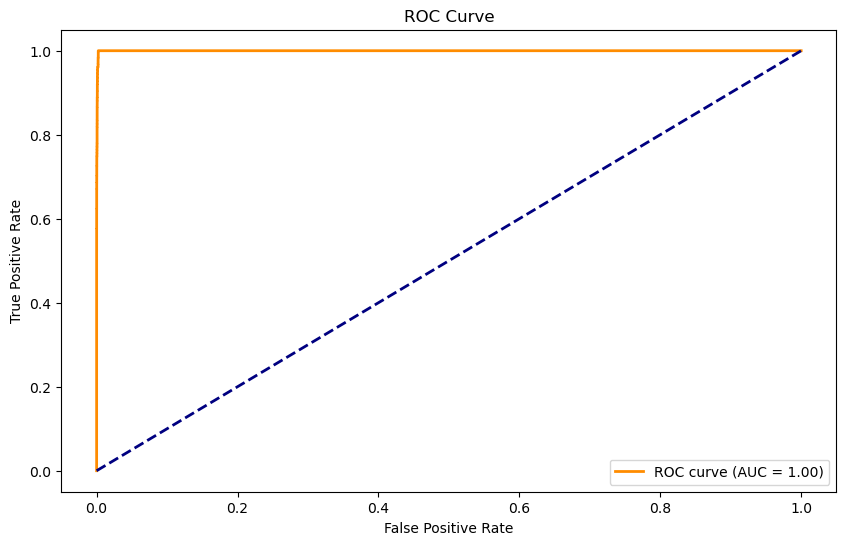

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_positive_class_focal)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


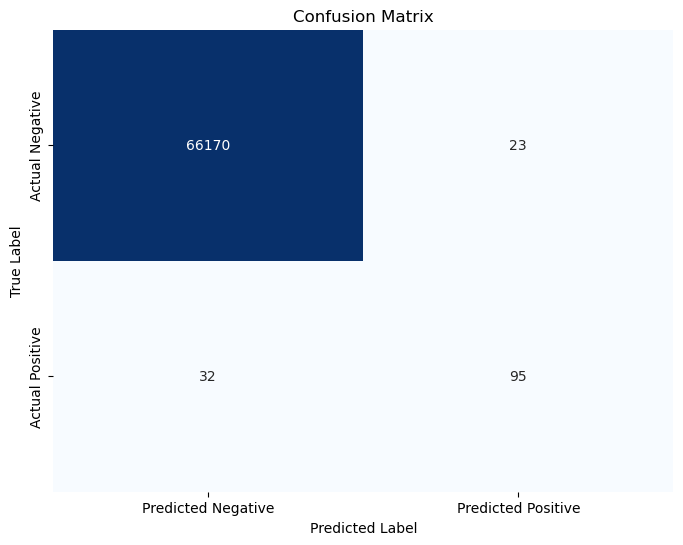

In [ ]:

#Confusion matrix
#shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1.
#In the second row, we note that all class 1 entries were erroneously predicted as class 0.

# Assuming you have the binary predictions (0 or 1) from your model
y_pred_binary = (y_pred_prob_positive_class_focal >= threshold).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


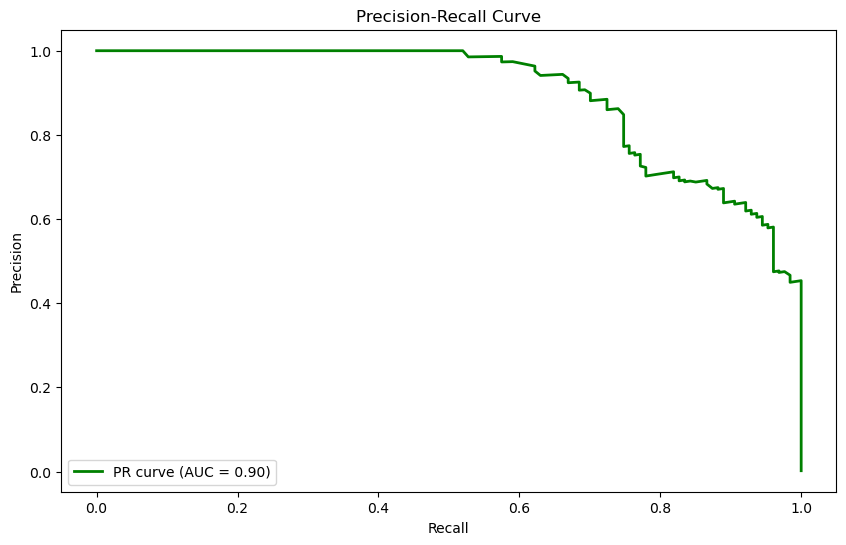

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming you have precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_positive_class_focal)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
